In [ ]:
import numpy as np
import cvxpy as cvx
import control as ctrl
import scipy.linalg as linalg
import matplotlib.pyplot as plt

from lib.lure import build_lure_system
from lib.algorithms_constrained import *

In [2]:
# Matplotlib settings
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

### Show $\mathcal{O}(\mathcal{P}_T)$ regret (Theorem 4)

In [ ]:
def show_regret_with_pIQC(algo, m, L):

    eps = 1e-6

    ### retrieve algorithm
    G, p, q = algo(m, L)

    ### Get algorithm dimensions
    n_xi = G.nstates
    n_u  = G.ninputs  # = p + q

    # zero matrices
    Z_xi = np.zeros((n_xi, n_xi))
    Z_u  = np.zeros((n_u,n_u))

    ### build Lur'e system
    G_hat, _, Multiplier, _ = build_lure_system(G, m, L, p, q, vIQC=False)
    A_hat, B_hat, C_hat, D_hat = ctrl.ssdata(G_hat)

    ### SDP variables
    P = cvx.Variable((n_xi, n_xi), symmetric=True)
    t = cvx.Variable(1, nonneg=True)

    ### LMI
    C_0 = np.block([[G.C[:1,:]],[np.zeros(G.C[1:,:].shape)]])
    CD = np.block([[C_hat, D_hat]])

    LMI_lyap = cvx.bmat([[A_hat.T @ P @ A_hat - P,   A_hat.T @ P @ B_hat],
                         [B_hat.T @ P @ A_hat,       B_hat.T @ P @ B_hat]])
    LMI_regret = np.block([[Z_xi,   C_0.T],
                           [C_0,      Z_u]])
    LMI_iqc = CD.T @ Multiplier @ CD

    LMI = LMI_lyap + LMI_regret + LMI_iqc

    ### solve optimization problem
    constraints = [P >> eps*np.eye(n_xi), 
                   LMI << 0,
                   P << cvx.multiply(t, np.eye(n_xi))]

    problem = cvx.Problem(cvx.Minimize(t), constraints)
    
    try:
        problem.solve(solver=cvx.MOSEK)
    except:
        pass

    flag = problem.status

    return flag, P.value

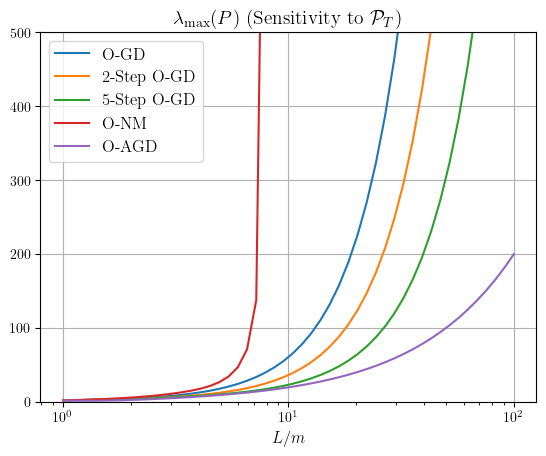

In [ ]:
algorithms = {
    "O-GD"        : {"callable": proximal_gradient},
    "2-Step O-GD" : {"callable": lambda m,L: multi_step_ogd(m,L,K=2)},
    "5-Step O-GD" : {"callable": lambda m,L: multi_step_ogd(m,L,K=5)},
    "O-NM"        : {"callable": proximal_nesterov},
    "O-AGD"       : {"callable": accelerated_ogd}
}

algos = algorithms.keys()
kappas = np.logspace(0, 2, 50)

# Initialize data storage
for algo in algorithms.values():
    algo["kappas"] = []
    algo["P_max"] = []

plt.figure(1)
plt.xlabel(r'$L/m$')
plt.title(r'$\lambda_{\max}(P)$ (Sensitivity to $\mathcal{P}_T$)')
plt.ylim([0,500])
plt.grid(True)

# Compute bound sensitivities
for name, algo_dict in algorithms.items():
    G = algo_dict["callable"]

    for kappa in kappas:
        flag, P = show_regret_with_pIQC(G, m=1, L=kappa)

        if flag is cvx.OPTIMAL:
            algo_dict["kappas"].append(kappa)
            algo_dict["P_max"].append(np.max(np.linalg.eigvalsh(P)))

    plt.semilogx(algorithms[name]["kappas"], algorithms[name]["P_max"], label=name)

plt.legend()
plt.show()


### Show $\mathcal{O}(\mathcal{S}_T + \mathcal{V}_T + \mathcal{G}_T)$ regret (Theorem 5)

In [ ]:
def show_regret_with_vIQC(algo, m, L, VT=1, ST=1, GT=1):

    eps = 1e-6

    ### retrieve algorithm
    G, p, q = algo(m, L)
    AG, BG, CG, DG = ctrl.ssdata(G)

    ### Get algorithm dimensions
    n_xi = G.nstates
    n_y  = G.noutputs # = p + q
    n_u  = G.ninputs  # = n_y

    ### augment plant with delta models
    BG_aug = np.block([[BG, np.eye(n_xi), np.zeros((n_xi,p))]])
    DG_aug = np.block([[DG, np.zeros((n_y, n_xi)), np.zeros((n_y, p))]])
    G_aug  = ctrl.ss(AG, BG_aug, CG, DG_aug, dt=1)

    ### build Lur'e system
    G_hat, Psi, Multiplier, Variables = build_lure_system(G_aug, m, L, p, q, vIQC=True)
    A_hat, B_hat, C_hat, D_hat = ctrl.ssdata(G_hat)

    # get dimensions
    n_eta  = G_hat.nstates
    n_psi  = G_hat.noutputs
    n_zeta = Psi.nstates

    # zero matrices
    Z_eta = np.zeros((n_eta, n_eta))
    Z_u   = np.zeros((n_u, n_u))

    # SDP variables
    P       = cvx.Variable((n_eta, n_eta), symmetric=True)
    t       = cvx.Variable(1, nonneg=True)
    gamm_xi = cvx.Variable(1, nonneg=True)
    gamm_dd = cvx.Variable(1, nonneg=True)
    lambdas_p_offby1 = Variables[2]

    ### LMI
    LMI_inner = cvx.bmat([
                [-P,                         np.zeros((n_eta, n_eta)), np.zeros((n_eta, n_psi)), np.zeros((n_eta, n_xi)),             np.zeros((n_eta, p))],
                [np.zeros((n_eta, n_eta)),   P,                        np.zeros((n_eta, n_psi)), np.zeros((n_eta, n_xi)),             np.zeros((n_eta, p))],
                [np.zeros((n_psi, n_eta)),   np.zeros((n_psi, n_eta)), Multiplier,               np.zeros((n_psi, n_xi)),             np.zeros((n_psi, p))],
                [np.zeros((n_xi, n_eta)),    np.zeros((n_xi, n_eta)),  np.zeros((n_xi, n_psi)), -cvx.multiply(gamm_xi, np.eye(n_xi)), np.zeros((n_xi, p)) ],
                [np.zeros((p, n_eta)),       np.zeros((p, n_eta)),     np.zeros((p, n_psi)),     np.zeros((p, n_xi)),                -cvx.multiply(gamm_dd, np.eye(p))]
    ])


    LMI_outer = cvx.bmat([
        [np.eye(n_eta), np.zeros((n_eta, n_u + n_xi + p))],
        [np.block([[A_hat, B_hat]])],
        [np.block([[C_hat, D_hat]])],
        [np.zeros((n_xi, n_eta + n_u)), np.eye(n_xi), np.zeros((n_xi,p))],
        [np.zeros((p, n_eta + n_u + n_xi)), np.eye(p)]
    ])

    
    C_x = np.block([[CG[:1,:]],
                    [np.zeros(CG[1:,:].shape)]])
    C_0 = np.block([[C_x, np.zeros((n_y,n_zeta))]])

    LMI_regret = np.block([[Z_eta, C_0.T],
                           [C_0,     Z_u]])
    LMI_regret = linalg.block_diag(LMI_regret, np.zeros((n_xi+p,n_xi+p)))

    LMI = LMI_outer.T @ LMI_inner @ LMI_outer + LMI_regret

    constraints = [P >> eps*np.eye(n_eta), 
                   LMI << 0,
                   P << cvx.multiply(t, np.eye(n_eta))]

    ### Solve problem
    gamm1 = gamm_xi
    gamm2 = p*gamm_dd
    gamm3 = (L-m)*cvx.sum(lambdas_p_offby1)
    obj   = t + gamm1*ST + gamm2*GT + gamm3*VT

    problem = cvx.Problem(cvx.Minimize(obj), constraints)
    try:
        problem.solve(solver=cvx.MOSEK)
    except:
        pass

    flag = problem.status

    return flag, gamm1.value, gamm2.value, gamm3.value

In [ ]:
algorithms = {
    "O-GD"        : {"callable": proximal_gradient},
    "2-Step O-GD" : {"callable": lambda m,L: multi_step_ogd(m,L,K=2)},
    "5-Step O-GD" : {"callable": lambda m,L: multi_step_ogd(m,L,K=5)},
    "O-NM"        : {"callable": proximal_nesterov},
    "O-AGD"       : {"callable": accelerated_ogd}
}


algos = algorithms.keys()
kappas = np.logspace(0, 2, 50)

# Foresight knowledge
ST = 1
VT = 1
GT = 1

# Initialize data storage
for algo in algorithms.values():
    algo["kappas"] = []
    algo["P_max"] = []
    algo["gamma1"] = []
    algo["gamma2"] = []
    algo["gamma3"] = []

# Compute bound sensitivities
for name, algo_dict in algorithms.items():
    G = algo_dict["callable"]

    for kappa in kappas:
        flag, gamma1, gamma2, gamma3 = show_regret_with_vIQC(G, m=1, L=kappa, VT=VT, ST=ST, GT=GT)

        if flag is cvx.OPTIMAL:
            algo_dict["kappas"].append(kappa)
            algo_dict["gamma1"].append(gamma1)
            algo_dict["gamma2"].append(gamma2)
            algo_dict["gamma3"].append(gamma3)



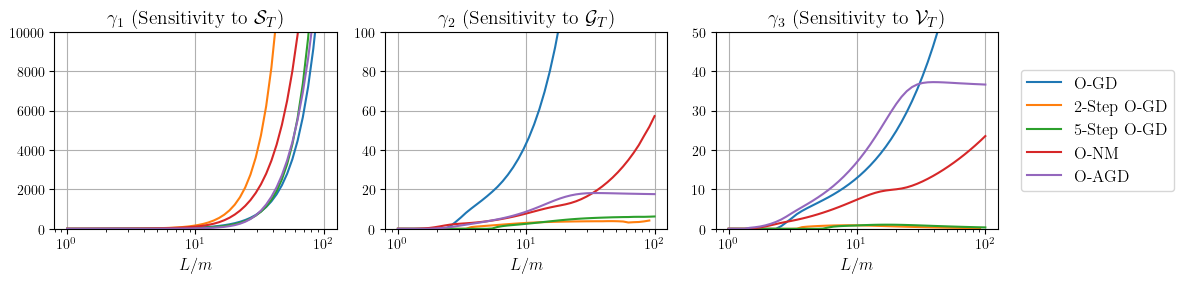

In [15]:
### Create plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

gamma_labels = [r"$\gamma_1$ (Sensitivity to $\mathcal{S}_T$)", r"$\gamma_2$ (Sensitivity to $\mathcal{G}_T$)", r"$\gamma_3$ (Sensitivity to $\mathcal{V}_T$)"]
gamma_keys = ["gamma1", "gamma2", "gamma3"]

for i, (ax, gamma_label, gamma_key) in enumerate(zip(axs, gamma_labels, gamma_keys)):
    for name, algo_dict in algorithms.items():
        ax.semilogx(algo_dict["kappas"], algo_dict[gamma_key], label=name)
    ax.set_title(gamma_label)
    ax.set_xlabel(r"$L/m$")
    ax.grid(True)

axs[0].set_ylim([0,10000])
axs[1].set_ylim([0,100])
axs[2].set_ylim([0,50])

axs[-1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()